<a href="https://colab.research.google.com/github/Smoulvad01/AI-C1-image-/blob/main/Image_Analysis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# <font color='green'>Import</font>

In [2]:
import cv2
from PIL import Image # To display images
from sklearn.decomposition import NMF, PCA

# TensorFlow and tf.keras
import tensorflow as tf
from keras.utils.vis_utils import plot_model

# Helper libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from sklearn.pipeline import Pipeline
import os
from livelossplot import PlotLossesKeras

# load models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# metrics and evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report

reload(plt)
np.set_printoptions(suppress=True)
print(tf.__version__)




2.12.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font color='green'>Load and Process the Data</font>

In [4]:
# Use this if working in Jupyter Notebook (not Colab)
directory_train = "/content/drive/MyDrive/dataset_new/train"
directory_test = "/content/drive/MyDrive/dataset_new/test"

In [5]:
def load_image_dataset(directory):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='grayscale',
        batch_size=32,
        image_size=(256, 256),
        shuffle=True,
        seed=42,
        validation_split=False,
        interpolation='mitchellcubic',
        follow_links=False,
        crop_to_aspect_ratio=False,
    )
    return dataset

In [6]:
train_images = load_image_dataset(directory_train)
test_images = load_image_dataset(directory_test)

Found 1234 files belonging to 2 classes.
Found 218 files belonging to 2 classes.


In [7]:
# labeling to give classnames 
class_names = train_images.class_names
print(class_names)

['Closed', 'Open']


# <font color='GREEN'>Build Models</font>

# <font color='blue'> Define X_train, y_train and PCA </font>

In [8]:
# Initialize lists to store the images and labels
train_images_list = []
train_labels_list = []

# Iterate over the dataset
for images, labels in train_images:
    # Flatten the images
    flat_images = tf.reshape(images, (images.shape[0], -1)).numpy()
    # Append the images and labels to the lists
    train_images_list.append(flat_images)
    train_labels_list.append(labels.numpy())

# Concatenate the list of arrays into a single numpy array
X_train = np.concatenate(train_images_list)
y_train = np.concatenate(train_labels_list)

In [9]:
# Initialize lists to store the images and labels
test_images_list = []
test_labels_list = []

# Iterate over the dataset
for images, labels in test_images:
    # Flatten the images
    flat_images = tf.reshape(images, (images.shape[0], -1)).numpy()
    # Append the images and labels to the lists
    test_images_list.append(flat_images)
    test_labels_list.append(labels.numpy())

# Concatenate the list of arrays into a single numpy array
X_test = np.concatenate(test_images_list)
y_test = np.concatenate(test_labels_list)

# <font color='blue'> Dummy Classifier </font>

In [11]:
# Train and evaluate a DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
print("Dummy Classifier accuracy: %f" % accuracy_score(y_test, y_pred_dummy))

print("Accuracy on training set: {:.3f}".format(dummy.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dummy.score(X_test, y_test)))

Dummy Classifier accuracy: 0.500000
Accuracy on training set: 0.500
Accuracy on test set: 0.500


# <font color='blue'> Logistic Regression & KNN </font>

In [13]:
# Defining the pipeline for Logistic Regression
pipe_log_reg = Pipeline([
    ("clf", LogisticRegression(max_iter=1000))
])

params_log_reg = { 
    "clf__C": [0.001, 0.01, 0.1, 1],
}

# Perform GridSearchCV for Logistic Regression
grid_search_log_reg = GridSearchCV(pipe_log_reg, params_log_reg, verbose=2, cv=3)
grid_search_log_reg.fit(X_train, y_train)

# Print the best parameters and score for Logistic Regression
print(f"Best score (Logistic Regression): {grid_search_log_reg.best_score_:.3f}")
print("Best parameters set (Logistic Regression):")
best_parameters_log_reg = grid_search_log_reg.best_estimator_.get_params()
for param_name in sorted(params_log_reg.keys()):
    print(f"\t{param_name}: {best_parameters_log_reg[param_name]}")

# Print the accuracy scores for Logistic Regression
print("Train (Logistic Regression)", grid_search_log_reg.score(X_train, y_train))
print("Test (Logistic Regression)", grid_search_log_reg.score(X_test, y_test))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .......................................clf__C=0.001; total time= 2.5min
[CV] END .......................................clf__C=0.001; total time= 2.3min
[CV] END .......................................clf__C=0.001; total time= 2.2min
[CV] END ........................................clf__C=0.01; total time= 2.2min
[CV] END ........................................clf__C=0.01; total time= 2.4min
[CV] END ........................................clf__C=0.01; total time= 2.6min
[CV] END .........................................clf__C=0.1; total time= 2.7min
[CV] END .........................................clf__C=0.1; total time= 2.0min
[CV] END .........................................clf__C=0.1; total time= 2.8min
[CV] END ...........................................clf__C=1; total time= 2.2min
[CV] END ...........................................clf__C=1; total time= 2.1min
[CV] END ........................................

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best score (Logistic Regression): 0.885
Best parameters set (Logistic Regression):
	clf__C: 0.001
Train (Logistic Regression) 1.0
Test (Logistic Regression) 0.8944954128440367


In [14]:
# Defining the pipeline for KNeighborsClassifier
pipe_knn = Pipeline([
    ("clf", KNeighborsClassifier())
])

params_knn = {
    "clf__n_neighbors": np.arange(1,20),
    "clf__metric": ["euclidean", "cosine", "manhattan"],
    "clf__weights": ["uniform", "distance"]
}

# Perform GridSearchCV for KNeighborsClassifier
grid_search_knn = GridSearchCV(pipe_knn, params_knn, verbose=2, cv=3)
grid_search_knn.fit(X_train, y_train)

# Print the best parameters and score for KNeighborsClassifier
print(f"Best score (KNN): {grid_search_knn.best_score_:.3f}")
print("Best parameters set (KNN):")
best_parameters_knn = grid_search_knn.best_estimator_.get_params()
for param_name in sorted(params_knn.keys()):
    print(f"\t{param_name}: {best_parameters_knn[param_name]}")

# Print the accuracy scores for KNeighborsClassifier
print("Train (KNN)", grid_search_knn.score(X_train, y_train))
print("Test (KNN)", grid_search_knn.score(X_test, y_test))

Fitting 3 folds for each of 114 candidates, totalling 342 fits
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   3.7s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   3.1s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   4.3s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   2.9s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   2.7s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   2.7s
[CV] END clf__metric=euclidean, clf__n_neighbors=2, clf__weights=uniform; total time=   2.8s
[CV] END clf__metric=euclidean, clf__n_neighbors=2, clf__weights=uniform; total time=   4.5s
[CV] END clf__metric=euclidean, clf__n_neighbors=2, clf__weights=uniform; total time=   2.7s
[CV] END clf__metric=euclidean, clf__n_neighbors=2, clf__weights=distance; total time=   2.8s
[CV

## Dummy Classifier, KNN and Logistic Regression Evaluation

Metrics for DummyClassifier:
Train accuracy:  0.5
Test accuracy:  0.5
Classification report (Test): 
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       109
           1       0.00      0.00      0.00       109

    accuracy                           0.50       218
   macro avg       0.25      0.50      0.33       218
weighted avg       0.25      0.50      0.33       218



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


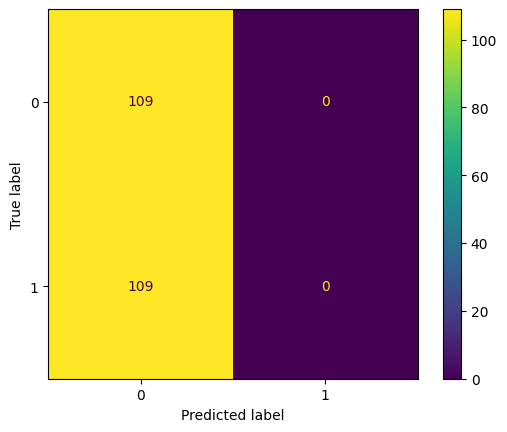

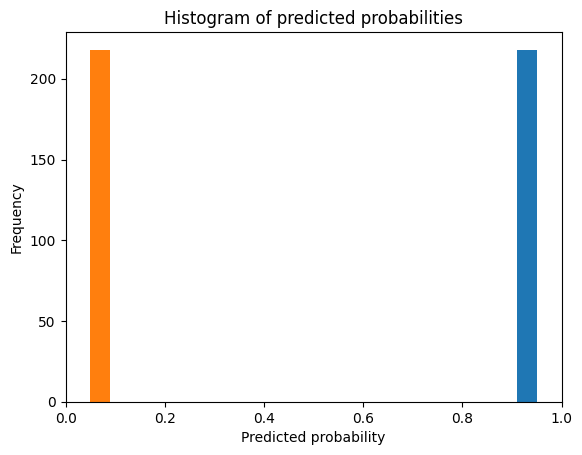

Metrics for Logistic Regression (Before GridSearch):


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  1.0
Test accuracy:  0.8990825688073395
Classification report (Test): 
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       109
           1       0.91      0.88      0.90       109

    accuracy                           0.90       218
   macro avg       0.90      0.90      0.90       218
weighted avg       0.90      0.90      0.90       218



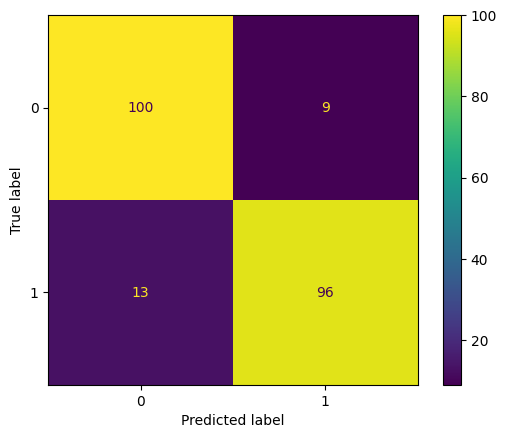

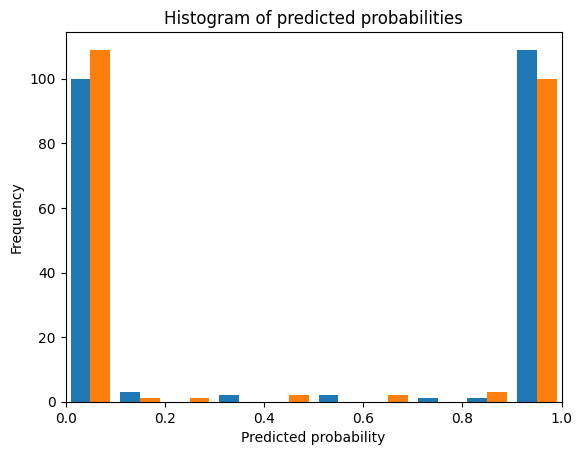

Metrics for Logistic Regression (After GridSearch):


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  1.0
Test accuracy:  0.8944954128440367
Classification report (Test): 
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       109
           1       0.91      0.88      0.89       109

    accuracy                           0.89       218
   macro avg       0.89      0.89      0.89       218
weighted avg       0.89      0.89      0.89       218



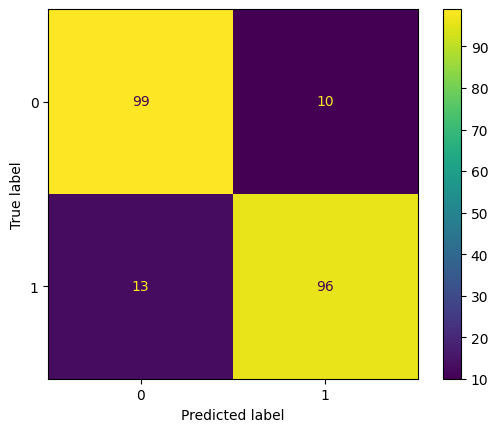

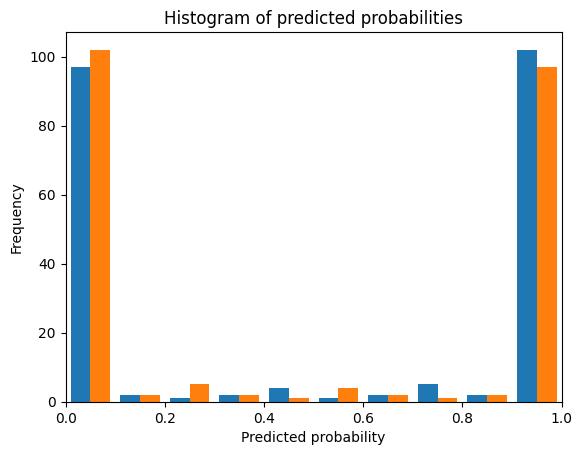

Metrics for KNN (Before GridSearch):
Train accuracy:  0.9019448946515397
Test accuracy:  0.8211009174311926
Classification report (Test): 
              precision    recall  f1-score   support

           0       0.75      0.97      0.84       109
           1       0.96      0.67      0.79       109

    accuracy                           0.82       218
   macro avg       0.85      0.82      0.82       218
weighted avg       0.85      0.82      0.82       218



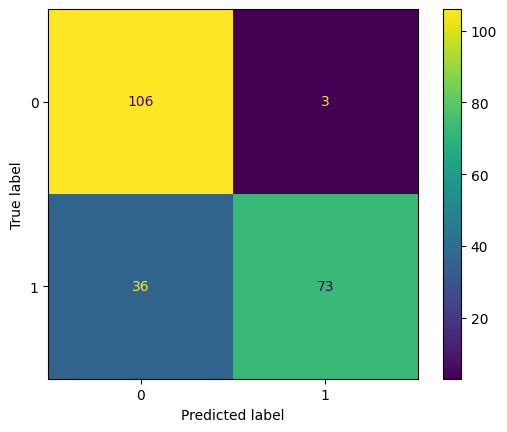

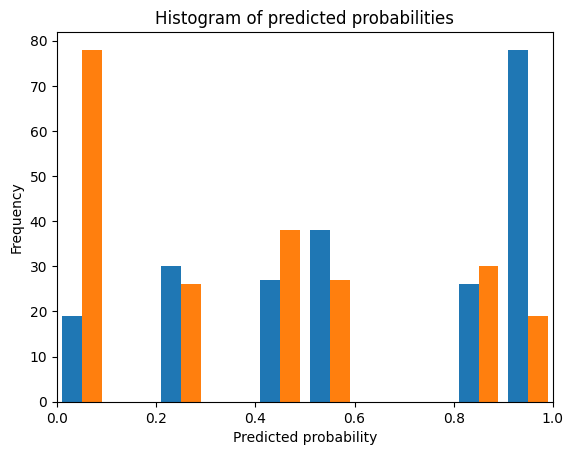

Metrics for KNN (After GridSearch):
Train accuracy:  1.0
Test accuracy:  0.8669724770642202
Classification report (Test): 
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       109
           1       0.97      0.76      0.85       109

    accuracy                           0.87       218
   macro avg       0.88      0.87      0.87       218
weighted avg       0.88      0.87      0.87       218



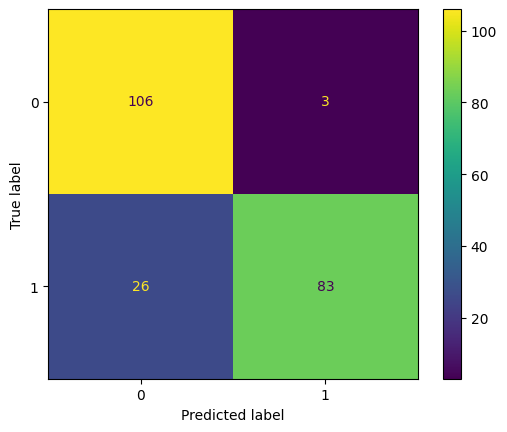

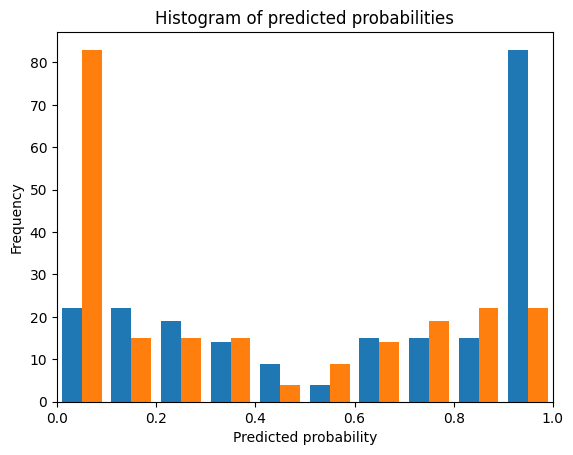

In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate a model and print evaluation metrics."""
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Predict values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Print accuracy scores
    print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
    print("Test accuracy: ", accuracy_score(y_test, y_test_pred))

    # Print classification report
    print("Classification report (Test): ")
    print(classification_report(y_test, y_test_pred))

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

    # Check if the model has predict_proba method
    if hasattr(model, "predict_proba"):
        # Compute predicted probabilities
        y_test_pred_proba = model.predict_proba(X_test)

        # Create a histogram of the predicted probabilities
        plt.hist(y_test_pred_proba, bins=10)
        plt.xlim(0, 1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability')
        plt.ylabel('Frequency')
        plt.show()

# Print metrics for DummyClassifier
print("Metrics for DummyClassifier:")
evaluate_model(dummy, X_train, X_test, y_train, y_test)

# Print metrics for Logistic Regression BEFORE GridSearch 
print("Metrics for Logistic Regression (Before GridSearch):")
evaluate_model(LogisticRegression(max_iter=1000), X_train, X_test, y_train, y_test)

# Print metrics for Logistic Regression AFTER GridSearch
print("Metrics for Logistic Regression (After GridSearch):")
evaluate_model(grid_search_log_reg.best_estimator_, X_train, X_test, y_train, y_test)

# Print metrics for KNeighborsClassifier BEFORE GridSearch
print("Metrics for KNN (Before GridSearch):")
evaluate_model(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

# Print metrics for KNeighborsClassifier AFTER GridSearch
print("Metrics for KNN (After GridSearch):")
evaluate_model(grid_search_knn.best_estimator_, X_train, X_test, y_train, y_test)


figure out how to use this for evaluation and confusion matrix

# <font color='blue'> CNN </font>

In [ ]:
##Best performance until now

# Load a convolutional base with pre-trained weights
base_model = tf.keras.applications.MobileNet(
    weights='imagenet',  # Pre-trained on ImageNet
    include_top=False,  # Do not include the ImageNet classifier at the top
    pooling='avg')  # Global average pooling applied after the last convolutional block

# Freeze the base model
base_model.trainable = False

# Add a new classifier layers on top
model = tf.keras.Sequential([
    base_model,  # The base model
    tf.keras.layers.Dense(224, activation='relu'),  # Dense layer with 256 units
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),  # Binary classification so only 1 output unit with sigmoid activation
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define number of epochs
num_epochs = 10

# Train the model
history = model.fit(train_images, 
                    epochs=num_epochs)
                #    validation_data=test_images)

Epoch 1/10
39/39 [==============================] - 23s 514ms/step - loss: 0.3382 - accuracy: 0.8525
Epoch 2/10
39/39 [==============================] - 22s 546ms/step - loss: 0.0980 - accuracy: 0.9716
Epoch 3/10
39/39 [==============================] - 31s 763ms/step - loss: 0.0608 - accuracy: 0.9846
Epoch 4/10
39/39 [==============================] - 29s 718ms/step - loss: 0.0462 - accuracy: 0.9878
Epoch 5/10
39/39 [==============================] - 25s 622ms/step - loss: 0.0368 - accuracy: 0.9911
Epoch 6/10
39/39 [==============================] - 24s 601ms/step - loss: 0.0275 - accuracy: 0.9927
Epoch 7/10
39/39 [==============================] - 25s 604ms/step - loss: 0.0247 - accuracy: 0.9968
Epoch 8/10
39/39 [==============================] - 24s 589ms/step - loss: 0.0191 - accuracy: 0.9959
Epoch 9/10
39/39 [==============================] - 18s 448ms/step - loss: 0.0182 - accuracy: 0.9968
Epoch 10/10
39/39 [==============================] - 24s 599ms/step - loss: 0.0168 - accura

### CNN Evaluation 

In [16]:
# tomas add the code here for confusion matrix, histogram, and classification report

# <font color='GREEN'>Using Trained Model</font>

In [17]:
# tomas add here the code to run the predictions on the eye images of Laurits you and me